In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

from astropy.table import Table,join,hstack,vstack
import glob
import numpy as np
import matplotlib.pyplot as plt
import corner
from scipy.optimize import curve_fit


In [2]:
# First read in the unvalidated GALAH DR4 file
galah = Table.read('../spectrum_post_processing//galah_dr4_allspec_not_validated.fits')
#galah = galah[galah['flag_sp_fit'] == 0]

In [3]:
gbs = Table.read('literature_data//GALAH_GBS2.1.fits')

In [4]:
gbs[-1]['sobject_id'] = 210115002201239

In [5]:
gbs_galah_match = []
galah_gbs_match = []

for each_sobject_id in range(len(galah['sobject_id'])):
    if galah['sobject_id'][each_sobject_id] not in [140709001901194,150204002101256]:
        try:
            side_a = np.where(
                    galah['sobject_id'][each_sobject_id] == gbs['sobject_id']
                )[0][0]
            side_b = each_sobject_id
            gbs_galah_match.append(side_a)
            galah_gbs_match.append(side_b)
        except:
            pass
gbs_galah_match = np.array(gbs_galah_match)
galah_gbs_match = np.array(galah_gbs_match)


In [6]:
gbs[gbs_galah_match][:10]

sobject_id,P2,P3,P4,P5,StarID1,StarID2,StarID3,StarID4,RAJ2000,DEJ2000,SpType,Teff,e_Teff,logg,e_logg,__Fe_H_,e__Fe_H_,logeps_Mg_,e_logeps_Mg_,logeps_Si_,e_logeps_Si_,logeps_Ca_,e_logeps_Ca_,logeps_Ti_,e_logeps_Ti_,logeps_Sc_,e_logeps_Sc_,logeps_V_,e_logeps_V_,logeps_Cr_,e_logeps_Cr_,logeps_Mn_,e_logeps_Mn_,logeps_Co_,e_logeps_Co_,logeps_Ni_,e_logeps_Ni_,__Mg_H_,e__Mg_H_,__Si_H_,e__Si_H_,__Ca_H_,e__Ca_H_,__Ti_H_,e__Ti_H_,__Sc_H_,e__Sc_H_,__V_H_,e__V_H_,__Cr_H_,e__Cr_H_,__Mn_H_,e__Mn_H_,__Co_H_,e__Co_H_,__Ni_H_,e__Ni_H_,SimbadName,GroupID,GroupSize
,,,,,,,,,deg,deg,,K,K,[cm/s2],[cm/s2],[Sun],[Sun],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],,,
int64,bytes2,bytes2,bytes2,bytes2,bytes9,bytes8,bytes9,int64,float64,float64,bytes15,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes9,int32,int32
131216002601003,P2,P3,P4,P5,mu Leo,HD85503,HIP48455,643819484616249984,148.19090416666666,26.006952777777773,K2III,4474,60,2.51,0.11,0.25,0.15,8.12,0.11,8.01,0.09,6.6,0.12,5.22,0.1,3.45,0.06,4.23,0.08,5.91,0.08,5.39,0.2,5.34,0.09,6.5,0.12,0.466,0.132,0.522,0.132,0.28,0.139,0.322,0.157,0.23,0.106,0.296,0.13,0.335,0.134,0.087,0.287,0.452,0.162,0.324,0.154,mu Leo,1,2
131216003201003,P2,P3,P4,P5,HD 84937,HD84937,HIP48152,615943806835727872,147.23374166666665,13.744255555555554,sdF5,6356,97,4.06,0.04,-2.03,0.08,5.89,0.11,5.76,0.18,4.66,0.08,3.24,0.11,1.33,0.15,nan,nan,3.35,0.07,nan,nan,nan,nan,4.12,0.12,-1.764,0.12,-1.731,0.177,-1.665,0.093,-1.664,0.119,-1.895,0.157,nan,nan,-2.228,0.101,nan,nan,nan,nan,-2.062,0.146,HD 84937,2,2
131216002601003,P2,P3,P4,P5,mu Leo,HD85503,HIP48455,643819484616249984,148.19090416666666,26.006952777777773,K2III,4474,60,2.51,0.11,0.25,0.15,8.12,0.11,8.01,0.09,6.6,0.12,5.22,0.1,3.45,0.06,4.23,0.08,5.91,0.08,5.39,0.2,5.34,0.09,6.5,0.12,0.466,0.132,0.522,0.132,0.28,0.139,0.322,0.157,0.23,0.106,0.296,0.13,0.335,0.134,0.087,0.287,0.452,0.162,0.324,0.154,mu Leo,1,2
131216003201003,P2,P3,P4,P5,HD 84937,HD84937,HIP48152,615943806835727872,147.23374166666665,13.744255555555554,sdF5,6356,97,4.06,0.04,-2.03,0.08,5.89,0.11,5.76,0.18,4.66,0.08,3.24,0.11,1.33,0.15,nan,nan,3.35,0.07,nan,nan,nan,nan,4.12,0.12,-1.764,0.12,-1.731,0.177,-1.665,0.093,-1.664,0.119,-1.895,0.157,nan,nan,-2.228,0.101,nan,nan,nan,nan,-2.062,0.146,HD 84937,2,2
131220004401099,P2,P3,P4,P5,ksi Hya,HD100407,HIP56343,3478394889482871808,173.25047916666665,-31.85762222222222,G7III,5044,40,2.87,0.02,0.16,0.2,7.68,0.11,7.57,0.06,6.39,0.07,4.93,0.08,3.28,0.11,3.98,0.07,5.66,0.04,5.2,0.1,4.88,0.08,6.22,0.08,0.034,0.118,0.077,0.079,0.068,0.101,0.028,0.1,0.062,0.137,0.053,0.094,0.077,0.062,-0.105,0.18,-0.009,0.094,0.035,0.118,ksi Hya,3,2
131220004401099,P2,P3,P4,P5,ksi Hya,HD100407,HIP56343,3478394889482871808,173.25047916666665,-31.85762222222222,G7III,5044,40,2.87,0.02,0.16,0.2,7.68,0.11,7.57,0.06,6.39,0.07,4.93,0.08,3.28,0.11,3.98,0.07,5.66,0.04,5.2,0.1,4.88,0.08,6.22,0.08,0.034,0.118,0.077,0.079,0.068,0.101,0.028,0.1,0.062,0.137,0.053,0.094,0.077,0.062,-0.105,0.18,-0.009,0.094,0.035,0.118,ksi Hya,3,2
140708003401078,P2,P3,P4,P5,mu Ara,HD160691,HIP86796,5945941905576552448,266.03625416666665,-51.83405277777777,G3IV-V,--,--,4.3,0.03,0.35,0.13,8.01,0.04,7.82,0.04,6.64,0.05,5.29,0.05,3.62,0.06,4.36,0.03,5.95,0.04,5.73,0.04,5.31,0.03,6.6,0.05,0.36,0.063,0.327,0.045,0.32,0.069,0.388,0.08,0.401,0.076,0.427,0.067,0.37,0.058,0.43,0.087,0.424,0.06,0.416,0.069,mu Ara,--,--
140708005801203,P2,P3,P4,P5,bet Hyi,HD2151,HIP2021,4683897617108298752,6.437791666666666,-77.25424722222222,G0V,5873,45,3.98,0.02,-0.04,0.06,7

In [7]:
galah[galah_gbs_match][:10]

sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,best_spec4star,flag_sp,flag_sp_fit,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,flux_contr,e_flux_contr,rv_comp_nr,rv_comp_1,e_rv_comp_1,rv_comp_1_h,rv_comp_1_p,rv_comp_2,e_rv_comp_2,rv_comp_2_h,rv_comp_2_p,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,teff_comp_2,e_teff_comp_2,logg_comp_2,e_logg_comp_2,fe_h_comp_2,e_fe_h_comp_2,flag_fe_h_comp_2,vmic_comp_2,e_vmic_comp_2,vsini_comp_2,e_vsini_comp_2,li_fe,e_li_fe,flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613
int64,bytes16,int64,bytes17,int64,bytes6,float32,float64,float64,bool,int64,int64,int64,float32,float32,float32,float32,float32,int64,bytes16,bytes16,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
131216002601003,09524585+2600248,643819484617141504,mu_leo,-2,single,56642.72,148.19090270996094,26.006954193115234,False,12,0,524288,482.95697,569.14624,490.33646,281.54044,11.220633,94,4500_2.50_0.25,4500_2.00_0.25,211.25404,1.0,nan,1,14.046632,0.024187213,1.0,0.7177645,nan,nan,nan,nan,nan,nan,24.708995819091797,4603.1504,0.5729115,2.3020587,0.0020154908,0.25529182,0.00073226687,0,1.5309659,0.0008466149,3.1313229,0.004392894,nan,nan,nan,nan,nan,nan,-1,nan,nan,nan,nan,nan,0.0048906757,16,-0.6021001,0.0020779262,0,0.11448848,0.0014900735,0,-0.8977817,0.0036321247,0,0.56583136,0.0015666452,0,0.18115473,0.0010690916,0,-0.4088837,0.003409408,0,0.1695631,0.0010304176,0,-0.19792199,0.0060792463,0,-0.019801224,0.0016732769,0,0.12282218,0.0011272128,0,0.06925797,0.00061816076,0,0.21080834,0.0007640265,0,-0.013959047,0.0008370561,0,0.30306113,0.0012437714,0,0.39384001,0.00084116496,0,0.14120606,0.000665785,0,0.54192847,0.0031129615,0,-0.15697896,0.004351908,0,nan,0.0070293862,17,-0.10706926,0.0034076248,0,-0.14424297,0.0022483421,0,-0.063838065,0.0020791478,0,0.10601845,0.005019334,0,nan,0.0048856856,16,0.25979808,0.0045880005,0,-0.16982746,0.0019414669,0,-0.615519,0.0029408354,0

In [8]:
galah[galah_gbs_match][10:]

sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,best_spec4star,flag_sp,flag_sp_fit,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,flux_contr,e_flux_contr,rv_comp_nr,rv_comp_1,e_rv_comp_1,rv_comp_1_h,rv_comp_1_p,rv_comp_2,e_rv_comp_2,rv_comp_2_h,rv_comp_2_p,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,teff_comp_2,e_teff_comp_2,logg_comp_2,e_logg_comp_2,fe_h_comp_2,e_fe_h_comp_2,flag_fe_h_comp_2,vmic_comp_2,e_vmic_comp_2,vsini_comp_2,e_vsini_comp_2,li_fe,e_li_fe,flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613
int64,bytes16,int64,bytes17,int64,bytes6,float32,float64,float64,bool,int64,int64,int64,float32,float32,float32,float32,float32,int64,bytes16,bytes16,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
140709004401117,None,1823067317695766784,gam_sag,-2,binary,56847.688,299.6893005371094,19.49214744567871,False,92,0,524288,1633.5356,1957.6932,1566.8564,1015.9094,45.12922,99,teff_logg_fe_h,teff_logg_fe_h,60.387466,0.5916243,0.0023790377,2,-34.07588,0.0035709883,nan,nan,-32.8529,0.009233695,nan,nan,nan,nan,7.523891448974609,3936.675,0.22741292,0.8492881,0.0013522744,-0.37493557,7.806453e-05,0,1.5985454,0.0015024727,3.4556568,0.0059054918,3942.7644,0.30556142,0.87658,0.0019643211,-0.37493557,7.806453e-05,0,1.663659,0.002149655,6.045274,0.0055744103,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,nan,nan,-1,131.82,139.5,142.98,0.29086,0.73931074,0.020647997,0.18361683,-127.96629,0.030613335,0.10717554,-52.13814,nan,nan,nan,0.021399125,0.11802696,-41.546345
140710000801284,12202099+0318453,3701693091058501504,hd_107328,-2,single,56848.41,185.08741760253906,3.312570810317993,True,8,0,524288,1518.959

In [9]:
comparison = Table()

comparison['GBS'] = gbs['StarID1'][gbs_galah_match]
comparison['sobject_id'] = gbs['sobject_id'][gbs_galah_match]
comparison['teff_gbs'] = np.array([float(gbs['Teff'][gbs_galah_match][x]) for x in range(len(gbs['Teff'][gbs_galah_match]))])
comparison['teff_gbs'][comparison['teff_gbs'] < 0] = np.NaN
comparison['logg_gbs'] = gbs['logg'][gbs_galah_match]
comparison['fe_h_gbs'] = gbs['__Fe_H_'][gbs_galah_match]

comparison['e_teff_gbs'] = np.array([float(gbs['e_Teff'][gbs_galah_match][x]) for x in range(len(gbs['e_Teff'][gbs_galah_match]))])
comparison['e_logg_gbs'] = gbs['e_logg'][gbs_galah_match]
comparison['e_fe_h_gbs'] = gbs['e__Fe_H_'][gbs_galah_match]

comparison['teff'] = galah['teff'][galah_gbs_match]
comparison['e_teff'] = galah['e_teff'][galah_gbs_match]
comparison['logg'] = galah['logg'][galah_gbs_match]
comparison['e_logg'] = galah['e_logg'][galah_gbs_match]
comparison['fe_h'] = galah['fe_h'][galah_gbs_match]
comparison['e_fe_h'] = galah['fe_h'][galah_gbs_match]

comparison['flag_sp'] = galah['flag_sp'][galah_gbs_match]

<ipython-input-9-9f2e111cb5a7>:5: UserWarning: Warning: converting a masked element to nan.
  comparison['teff_gbs'] = np.array([float(gbs['Teff'][gbs_galah_match][x]) for x in range(len(gbs['Teff'][gbs_galah_match]))])
<ipython-input-9-9f2e111cb5a7>:10: UserWarning: Warning: converting a masked element to nan.
  comparison['e_teff_gbs'] = np.array([float(gbs['e_Teff'][gbs_galah_match][x]) for x in range(len(gbs['e_Teff'][gbs_galah_match]))])


In [10]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

In [11]:
lbol_bias = {}

for each_param in ['teff','logg','fe_h']:
    good = (
        np.isfinite(comparison[each_param]) & np.isfinite(comparison[each_param+'_gbs']) & (comparison['flag_sp'] < 32)
        )

    sigma = np.sqrt(comparison['e_'+each_param][good]**2+comparison['e_'+each_param+'_gbs'][good]**2)
    
    lbol_bias[each_param] = weighted_avg_and_std(
              comparison[each_param][good] - comparison[each_param+'_gbs'][good],
              1./(comparison['e_'+each_param][good]**2+comparison['e_'+each_param+'_gbs'][good]**2))
    
    lbol_bias[each_param+'_simple'] = weighted_avg_and_std(
              comparison[each_param][good] - comparison[each_param+'_gbs'][good],
              np.min(sigma)/sigma)
    
good = (
        np.isfinite(comparison[each_param]) & np.isfinite(comparison[each_param+'_gbs'])
        )

In [12]:
# comparison_old = comparison
comparison = comparison[(np.isnan(comparison['teff_gbs']) | (abs(comparison['teff'] - comparison['teff_gbs']) < 400))]

/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


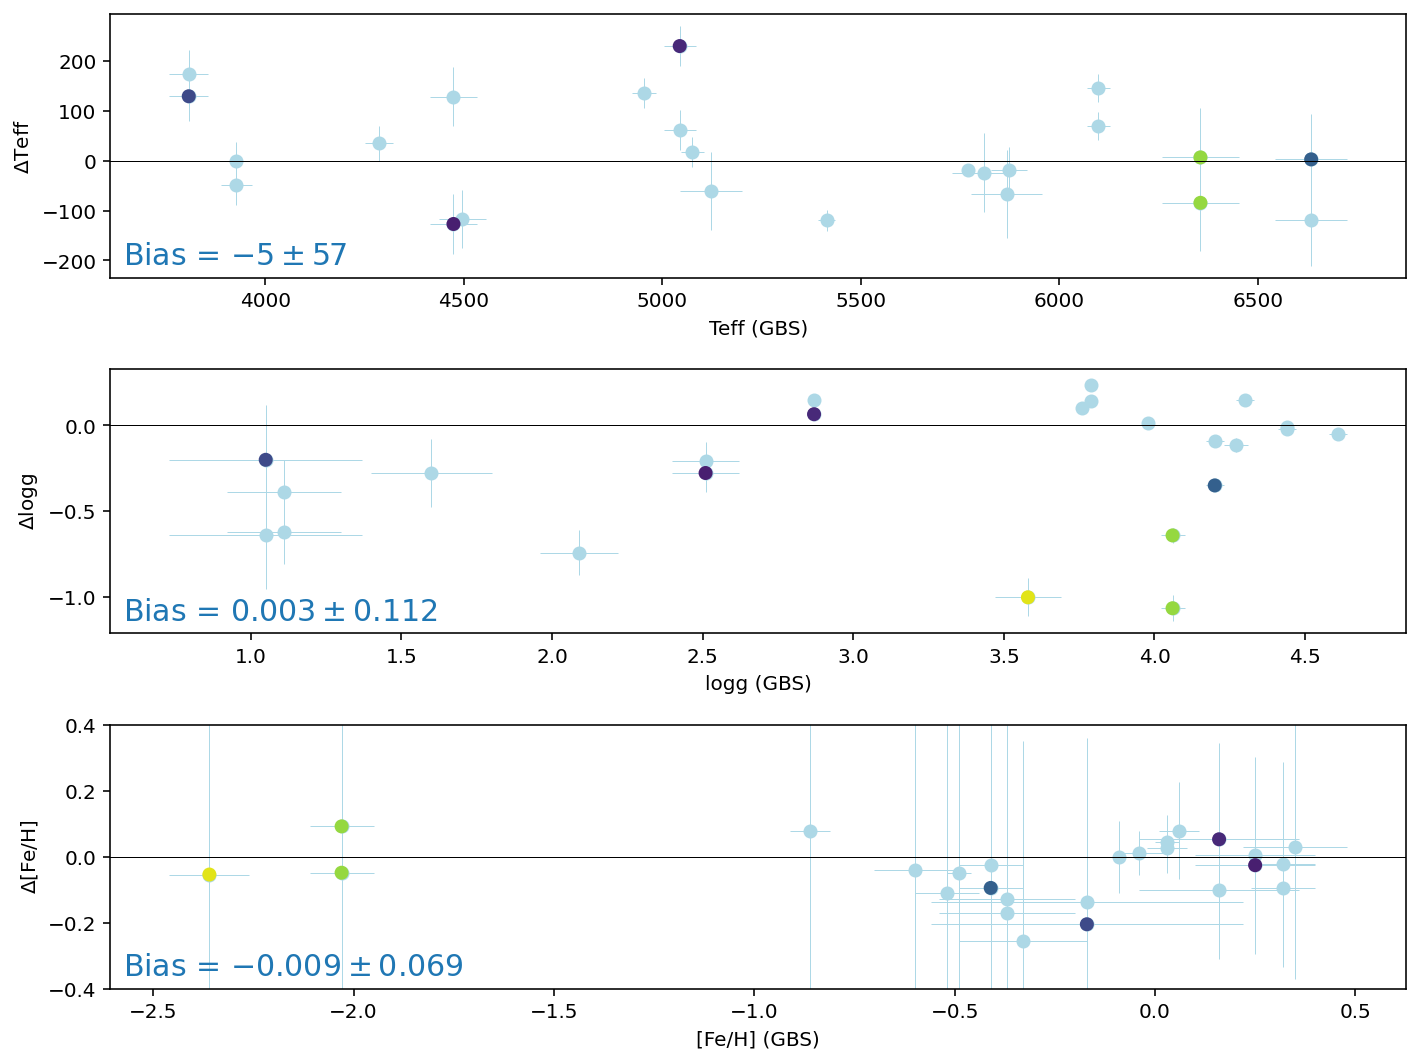

In [13]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10,7.5))

flagged = ~(comparison['flag_sp'] < 32)# & (comparison['logg'] > 2.5)

s1 = ax1.errorbar(
    comparison['teff_gbs'],
    comparison['teff'] - comparison['teff_gbs'],
    xerr = comparison['e_teff_gbs'],
    yerr = np.sqrt(comparison['e_teff_gbs']**2 + comparison['e_teff']**2),
    fmt = 'o', lw=0.5,
    label=r'not flagged',zorder=1,c='lightblue'
    )

ax1.scatter(
    comparison['teff_gbs'][flagged],
    comparison['teff'][flagged] - comparison['teff_gbs'][flagged],
    c = comparison['fe_h_gbs'][flagged],cmap='viridis_r', zorder=2,
    label=r'flagged',vmin=-2.5,vmax=0.5
)

s2 = ax2.errorbar(
    comparison['logg_gbs'],
    comparison['logg'] - comparison['logg_gbs'],
    xerr = comparison['e_logg_gbs'],
    yerr = np.sqrt(comparison['e_logg_gbs']**2 + comparison['e_logg']**2),
    fmt = 'o', lw=0.5, zorder=1,c='lightblue'
    )

ax2.scatter(
    comparison['logg_gbs'][flagged],
    comparison['logg'][flagged] - comparison['logg_gbs'][flagged],
    c = comparison['fe_h_gbs'][flagged],cmap='viridis_r', zorder=2,vmin=-2.5,vmax=0.5
)

s3 = ax3.errorbar(
    comparison['fe_h_gbs'],
    comparison['fe_h'] - comparison['fe_h_gbs'],
    xerr = comparison['e_fe_h_gbs'],
    yerr = np.sqrt(comparison['e_fe_h_gbs']**2 + comparison['e_fe_h']**2),
    fmt = 'o', lw=0.5, zorder=1,c='lightblue'
    )

ax3.scatter(
    comparison['fe_h_gbs'][flagged],
    comparison['fe_h'][flagged] - comparison['fe_h_gbs'][flagged],
    c = comparison['fe_h_gbs'][flagged],cmap='viridis_r', zorder=2,vmin=-2.5,vmax=0.5
)

# ax1.set_ylim(-300,300)
# ax2.set_ylim(-0.51,0.51)
ax3.set_ylim(-0.4,0.4)

ax1.axhline(0,lw=0.5,c='k')
ax2.axhline(0,lw=0.5,c='k')
ax3.axhline(0,lw=0.5,c='k')

ax1.set_xlabel('Teff (GBS)')
ax2.set_xlabel('logg (GBS)')
ax3.set_xlabel('[Fe/H] (GBS)')

ax1.set_ylabel(r'$\Delta$Teff')
ax2.set_ylabel(r'$\Delta$logg')
ax3.set_ylabel(r'$\Delta$[Fe/H]')

# ax1.text(0.01,0.05,r'Bias = $'+str('%.0f' % lbol_bias['teff'][0])+' \pm '+str('%.0f' % lbol_bias['teff'][1])+'$',transform=ax1.transAxes,color='C0',fontsize=15)
# ax2.text(0.01,0.05,r'Bias = $'+str('%.3f' % lbol_bias['logg'][0])+' \pm '+str('%.3f' % lbol_bias['logg'][1])+'$',transform=ax2.transAxes,color='C0',fontsize=15)
# ax3.text(0.01,0.05,r'Bias = $'+str('%.3f' % lbol_bias['fe_h'][0])+' \pm '+str('%.3f' % lbol_bias['fe_h'][1])+'$',transform=ax3.transAxes,color='C0',fontsize=15)
# ax1.text(0.01,0.15,r'Bias = $'+str('%.0f' % lbol_bias['teff_simple'][0])+' \pm '+str('%.0f' % lbol_bias['teff_simple'][1])+'$',transform=ax1.transAxes,color='C0',fontsize=15)
# ax2.text(0.01,0.15,r'Bias = $'+str('%.3f' % lbol_bias['logg_simple'][0])+' \pm '+str('%.3f' % lbol_bias['logg_simple'][1])+'$',transform=ax2.transAxes,color='C0',fontsize=15)
# ax3.text(0.01,0.15,r'Bias = $'+str('%.3f' % lbol_bias['fe_h_simple'][0])+' \pm '+str('%.3f' % lbol_bias['fe_h_simple'][1])+'$',transform=ax3.transAxes,color='C0',fontsize=15)
ax1.text(0.01,0.05,r'Bias = $'+str('%.0f' % lbol_bias['teff_simple'][0])+' \pm '+str('%.0f' % lbol_bias['teff_simple'][1])+'$',transform=ax1.transAxes,color='C0',fontsize=15)
ax2.text(0.01,0.05,r'Bias = $'+str('%.3f' % lbol_bias['logg_simple'][0])+' \pm '+str('%.3f' % lbol_bias['logg_simple'][1])+'$',transform=ax2.transAxes,color='C0',fontsize=15)
ax3.text(0.01,0.05,r'Bias = $'+str('%.3f' % lbol_bias['fe_h_simple'][0])+' \pm '+str('%.3f' % lbol_bias['fe_h_simple'][1])+'$',transform=ax3.transAxes,color='C0',fontsize=15)

#ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75),ncol=4, fancybox=True,handletextpad=-0.2,columnspacing=0.25)
#ax1.text(-0.05,1.37,r'$\Delta$ = GALAH DR4 - GBS 2.1',transform=ax1.transAxes,fontsize=20)

plt.tight_layout()
plt.savefig('figures/gbs_performance_lbol.png',bbox_inches='tight',dpi=300)

In [14]:
gbs_extended = Table.read('literature_data/GBS_Jofre_privatecomm.fits')
gbs_extended['tmass_id'] = np.array([str(x)[:16] for x in gbs_extended['2MASS']])

In [15]:
galah['tmass_id'] = np.array([str(x) for x in galah['tmass_id']])

In [16]:
gbs_extended_galah = join(gbs_extended, galah, keys='tmass_id')

In [17]:
gbs_extended_galah

HIP,2MASS,Teff_literature,logg_literature,FeH_literature,V_mag,K_mag,tmass_id,sobject_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,best_spec4star,flag_sp,flag_sp_fit,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,flux_contr,e_flux_contr,rv_comp_nr,rv_comp_1,e_rv_comp_1,rv_comp_1_h,rv_comp_1_p,rv_comp_2,e_rv_comp_2,rv_comp_2_h,rv_comp_2_p,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,teff_comp_2,e_teff_comp_2,logg_comp_2,e_logg_comp_2,fe_h_comp_2,e_fe_h_comp_2,flag_fe_h_comp_2,vmic_comp_2,e_vmic_comp_2,vsini_comp_2,e_vsini_comp_2,li_fe,e_li_fe,flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613
bytes10,bytes17,int16,float32,float32,float32,float32,str16,int64,int64,bytes17,int64,bytes6,float32,float64,float64,bool,int64,int64,int64,float32,float32,float32,float32,float32,int64,bytes16,bytes16,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
HIP 8102,01440402-1556141,5356,4.53,-0.51,3.5,1.68,01440402-1556141,140708006401203,2452378776434477184,k2_hermes,6575,single,56846.78,26.017013549804688,-15.937479972839355,True,8,0,524288,1960.4061,1625.7108,1208.3324,538.15436,5.323705,94,5250_4.50_-0.50,5250_4.00_-0.50,111.8479,1.0,nan,1,-16.33508,0.028313877,1.0,0.7011378,nan,nan,nan,nan,nan,nan,26.7758731842041,5294.382,0.26238307,4.3356133,0.0004154424,-0.54018664,0.00024031606,0,0.78984684,0.0008067548,2.819244,0.0062287645,nan,nan,nan,nan,nan,nan,-1,nan,nan,nan,nan,0.26569468,0.001741272,0,0.038321257,0.000674536,0,0.11697993,0.0015001656,0,-0.94464207,0.0018532365,0,0.0311632,0.0005587684,0,0.3128286,0.00048051716,0,0.25216413,0.003387929,0,0.16835856,0.0005576649,0,0.32371068,0.0032349275,0,0.2611836,0.00066896406,0,0.11320534,0.0007434168,0,0.20820619,0.00035368832,0,0.2291665,0.00035818855,0,-0.018810032,0.00028892094,0,-0.06952353,0.00035923359,0,0.047082167,0.0005239761,0,0.033907,0.00033181175,0,-0.0267023,0.0009526626,0,0.1029433,0.00089955947,0,nan,nan,2,nan,nan,2,-0.020139016,0.000772

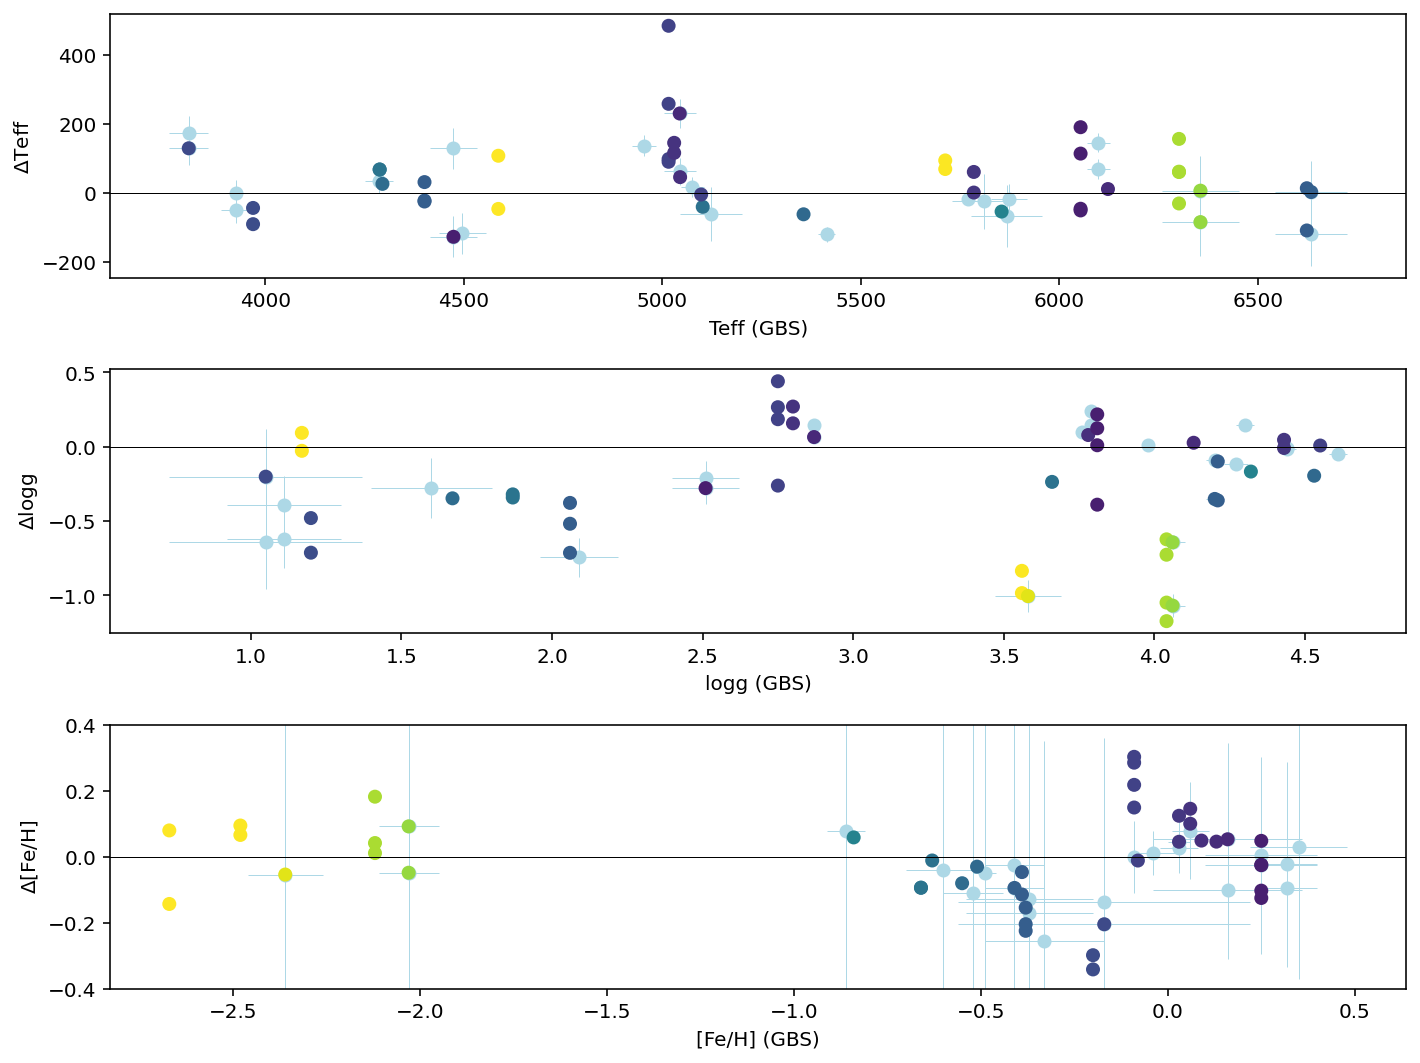

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10,7.5))

flagged = abs(gbs_extended_galah['teff'] - gbs_extended_galah['Teff_literature']) < 1000

# s1 = ax1.errorbar(
#     gbs_extended_galah['Teff_literature'],
#     gbs_extended_galah['teff'] - gbs_extended_galah['Teff_literature'],
#     xerr = comparison['e_teff_gbs'],
#     yerr = np.sqrt(comparison['e_teff_gbs']**2 + comparison['e_teff']**2),
#     fmt = 'o', lw=0.5,
#     label=r'not flagged',zorder=1,c='lightblue'
#     )

ax1.scatter(
    gbs_extended_galah['Teff_literature'][flagged],
    gbs_extended_galah['teff'][flagged] - gbs_extended_galah['Teff_literature'][flagged],
    c = gbs_extended_galah['FeH_literature'][flagged],cmap='viridis_r', zorder=2,
    label=r'flagged',vmin=-2.5,vmax=0.5
)

ax2.scatter(
    gbs_extended_galah['logg_literature'][flagged],
    gbs_extended_galah['logg'][flagged] - gbs_extended_galah['logg_literature'][flagged],
    c = gbs_extended_galah['FeH_literature'][flagged],cmap='viridis_r', zorder=2,vmin=-2.5,vmax=0.5
)


ax3.scatter(
    gbs_extended_galah['FeH_literature'][flagged],
    gbs_extended_galah['fe_h'][flagged] - gbs_extended_galah['FeH_literature'][flagged],
    c = gbs_extended_galah['FeH_literature'][flagged],cmap='viridis_r', zorder=2,vmin=-2.5,vmax=0.5
)

flagged = ~(comparison['flag_sp'] < 32)# & (comparison['logg'] > 2.5)

s1 = ax1.errorbar(
    comparison['teff_gbs'],
    comparison['teff'] - comparison['teff_gbs'],
    xerr = comparison['e_teff_gbs'],
    yerr = np.sqrt(comparison['e_teff_gbs']**2 + comparison['e_teff']**2),
    fmt = 'o', lw=0.5,
    label=r'not flagged',zorder=1,c='lightblue'
    )

ax1.scatter(
    comparison['teff_gbs'][flagged],
    comparison['teff'][flagged] - comparison['teff_gbs'][flagged],
    c = comparison['fe_h_gbs'][flagged],cmap='viridis_r', zorder=2,
    label=r'flagged',vmin=-2.5,vmax=0.5
)

s2 = ax2.errorbar(
    comparison['logg_gbs'],
    comparison['logg'] - comparison['logg_gbs'],
    xerr = comparison['e_logg_gbs'],
    yerr = np.sqrt(comparison['e_logg_gbs']**2 + comparison['e_logg']**2),
    fmt = 'o', lw=0.5, zorder=1,c='lightblue'
    )

ax2.scatter(
    comparison['logg_gbs'][flagged],
    comparison['logg'][flagged] - comparison['logg_gbs'][flagged],
    c = comparison['fe_h_gbs'][flagged],cmap='viridis_r', zorder=2,vmin=-2.5,vmax=0.5
)

s3 = ax3.errorbar(
    comparison['fe_h_gbs'],
    comparison['fe_h'] - comparison['fe_h_gbs'],
    xerr = comparison['e_fe_h_gbs'],
    yerr = np.sqrt(comparison['e_fe_h_gbs']**2 + comparison['e_fe_h']**2),
    fmt = 'o', lw=0.5, zorder=1,c='lightblue'
    )

ax3.scatter(
    comparison['fe_h_gbs'][flagged],
    comparison['fe_h'][flagged] - comparison['fe_h_gbs'][flagged],
    c = comparison['fe_h_gbs'][flagged],cmap='viridis_r', zorder=2,vmin=-2.5,vmax=0.5
)
# ax1.set_ylim(-300,300)
# ax2.set_ylim(-0.51,0.51)
ax3.set_ylim(-0.4,0.4)

ax1.axhline(0,lw=0.5,c='k')
ax2.axhline(0,lw=0.5,c='k')
ax3.axhline(0,lw=0.5,c='k')

ax1.set_xlabel('Teff (GBS)')
ax2.set_xlabel('logg (GBS)')
ax3.set_xlabel('[Fe/H] (GBS)')

ax1.set_ylabel(r'$\Delta$Teff')
ax2.set_ylabel(r'$\Delta$logg')
ax3.set_ylabel(r'$\Delta$[Fe/H]')

# ax1.text(0.01,0.05,r'Bias = $'+str('%.0f' % lbol_bias['teff'][0])+' \pm '+str('%.0f' % lbol_bias['teff'][1])+'$',transform=ax1.transAxes,color='C0',fontsize=15)
# ax2.text(0.01,0.05,r'Bias = $'+str('%.3f' % lbol_bias['logg'][0])+' \pm '+str('%.3f' % lbol_bias['logg'][1])+'$',transform=ax2.transAxes,color='C0',fontsize=15)
# ax3.text(0.01,0.05,r'Bias = $'+str('%.3f' % lbol_bias['fe_h'][0])+' \pm '+str('%.3f' % lbol_bias['fe_h'][1])+'$',transform=ax3.transAxes,color='C0',fontsize=15)
# ax1.text(0.01,0.15,r'Bias = $'+str('%.0f' % lbol_bias['teff_simple'][0])+' \pm '+str('%.0f' % lbol_bias['teff_simple'][1])+'$',transform=ax1.transAxes,color='C0',fontsize=15)
# ax2.text(0.01,0.15,r'Bias = $'+str('%.3f' % lbol_bias['logg_simple'][0])+' \pm '+str('%.3f' % lbol_bias['logg_simple'][1])+'$',transform=ax2.transAxes,color='C0',fontsize=15)
# ax3.text(0.01,0.15,r'Bias = $'+str('%.3f' % lbol_bias['fe_h_simple'][0])+' \pm '+str('%.3f' % lbol_bias['fe_h_simple'][1])+'$',transform=ax3.transAxes,color='C0',fontsize=15)
# ax1.text(0.01,0.05,r'Bias = $'+str('%.0f' % lbol_bias['teff_simple'][0])+' \pm '+str('%.0f' % lbol_bias['teff_simple'][1])+'$',transform=ax1.transAxes,color='C0',fontsize=15)
# ax2.text(0.01,0.05,r'Bias = $'+str('%.3f' % lbol_bias['logg_simple'][0])+' \pm '+str('%.3f' % lbol_bias['logg_simple'][1])+'$',transform=ax2.transAxes,color='C0',fontsize=15)
# ax3.text(0.01,0.05,r'Bias = $'+str('%.3f' % lbol_bias['fe_h_simple'][0])+' \pm '+str('%.3f' % lbol_bias['fe_h_simple'][1])+'$',transform=ax3.transAxes,color='C0',fontsize=15)

#ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75),ncol=4, fancybox=True,handletextpad=-0.2,columnspacing=0.25)
#ax1.text(-0.05,1.37,r'$\Delta$ = GALAH DR4 - GBS 2.1',transform=ax1.transAxes,fontsize=20)

plt.tight_layout()
# plt.savefig('figures/gbs_performance_lbol.png',bbox_inches='tight',dpi=300)